# Classic VRPs

This notebook shows how to use PyVRP to solve two classic variants of the VRP: the capacitated vehicle routing problem (CVRP), and the vehicle routing problem with time windows (VRPTW).
It builds on the tutorial by solving much larger instances, and going into more detail about the various plotting tools and diagnostics available in PyVRP.

A CVRP instance is defined on a complete graph $G=(V,A)$, where $V$ is the vertex set and $A$ is the arc set.
The vertex set $V$ is partitioned into $V=\{0\} \cup V_c$, where $0$ represents the depot and $V_c=\{1, \dots, n\}$ denotes the set of $n$ customers.
Each arc $(i, j) \in A$ has a weight $d_{ij} \ge 0$ that represents the travel distance from $i \in V$ to $j \in V$.
Each customer $i \in V_c$ has a demand $q_{i} \ge 0$.
The objective is to find a feasible solution that minimises the total distance.

A VRPTW instance additionally incorporates time aspects into the problem.
For the sake of exposition we assume the travel duration $t_{ij} \ge 0$ is equal to the travel distance $d_{ij}$ in this notebook.
Each customer $i \in V_c$ has a service time $s_{i} \ge 0$ and a (hard) time window $\left[e_i, l_i\right]$ that denotes the earliest and latest time that service can start.
A vehicle is allowed to arrive at a customer location before the beginning of the time window, but it must wait for the window to open to start the delivery.
Each vehicle must return to the depot before the end of the depot time window $H$.
The objective is to find a feasible solution that minimises the total distance.

Let's first import what we will use in this notebook.

In [1]:
pip install 'pyvrp @ git+https://github.com/DillonLeong996/PyVRP'

  Cloning https://github.com/DillonLeong996/PyVRP to /tmp/pip-install-0beozt0s/pyvrp_2b822d6bc99142e99500f4ecb7997e06
  Running command git clone --filter=blob:none --quiet https://github.com/DillonLeong996/PyVRP /tmp/pip-install-0beozt0s/pyvrp_2b822d6bc99142e99500f4ecb7997e06
  Resolved https://github.com/DillonLeong996/PyVRP to commit c16964638154d2418a8e05c88adef47e27b824a2
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 6.3 MB/s eta 0:00:00
  Created wheel for pyvrp: filename=pyvrp-0.12.0a0-cp311-cp311-manylinux_2_35_x86_64.whl size=1048116 sha256=b01426983a532a5cd0f4a7004d60863edfdf434c587d8f860198e98f6ea074d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-g6fq77av/wheels/1e/a3/53/f9ab9247eabdf5a2e7eda206b3eb6d9efe84ba25b788d9d8ce
Successfully built pyvrp


In [2]:
pip install --upgrade uv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 40.9 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
from tabulate import tabulate
from vrplib import read_solution

from pyvrp import Model, read
from pyvrp.plotting import (
    plot_coordinates,
    plot_instance,
    plot_result,
    plot_route_schedule,
)
from pyvrp.stop import MaxIterations, MaxRuntime

## The capacitated VRP

### Reading the instance

We will solve the `X-n439-k37` instance, which is part of the [X instance set](http://vrp.atd-lab.inf.puc-rio.br/index.php/en/new-instances) that is widely used to benchmark CVRP algorithms.
The function `pyvrp.read` reads the instance file and converts it to a `ProblemData` instance.
We pass the argument `round_func="round"` to compute the Euclidean distances rounded to the nearest integral, which is the convention for the X benchmark set.
We also load the best known solution to evaluate our solver later on.

### Note

Due to how the package installs `X-n439-k37.vrp` and `X-n439-k37.sol` must be manually inserted from examples/data into contents folder to run.

In [2]:
INSTANCE = read("/content/X-n439-k37.vrp", round_func="round")
BKS = read_solution("/content/X-n439-k37.sol")

Let's plot the instance and see what we have.

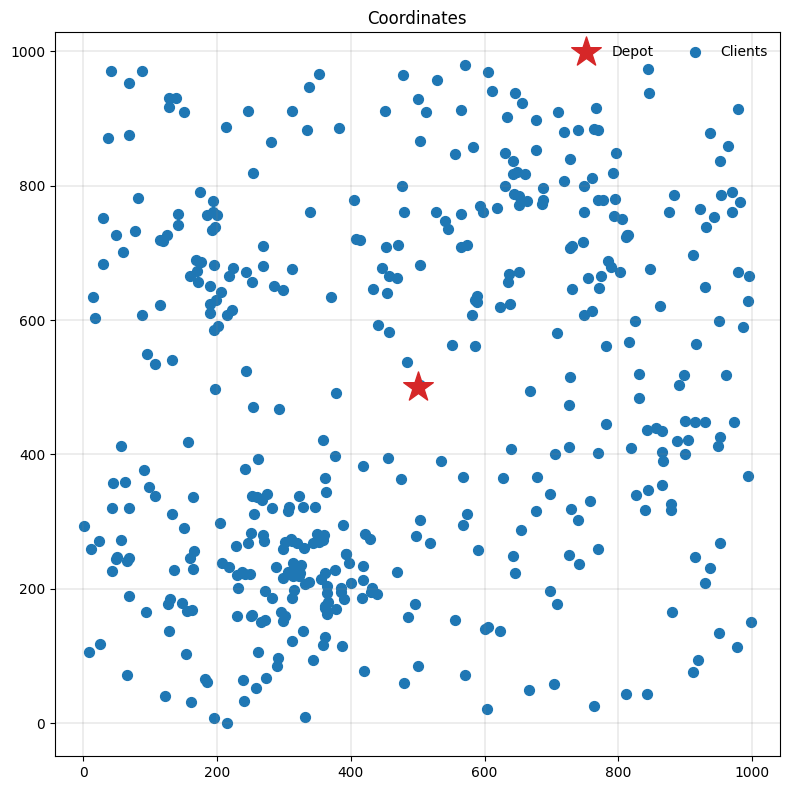

In [3]:
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(INSTANCE, ax=ax)
plt.tight_layout()

### Solving the instance

We will again use the `Model` interface to solve the instance.
The `Model` interface supports a convenient `from_data` method that can be used to instantiate a model from a known `ProblemData` object.

In [8]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxIterations(2000), seed=42, display=False)
print(result)

Solution results
    # routes: 37
     # trips: 37
   # clients: 438
   objective: 36627
    distance: 36627
    duration: 36627
# iterations: 2000
    run-time: 86.80 seconds

Routes
------
Route #1: 105 2 169 8 311 434 362 187 136 59 236 217
Route #2: 26 260 3 370 133 425 223 349 410 72 335 71
Route #3: 42 239 281 218 392 299 386 267 400 97 411 348
Route #4: 326 155 92 275 41 406 270 308 202 172
Route #5: 43 375 296 57 139 200 145 122 418 206 347 211
Route #6: 228 346 162 435 166 345 250 385 438 312 381 404
Route #7: 44 324 115 380 227 249 325 393 237 121 195 149
Route #8: 422 353 221 342 360 241 242 337 433 377 268 229
Route #9: 280 245 110 409 225 86 315 352 264 372 391 423
Route #10: 421 416 407 366 384 403 17 89 412 83 388 303
Route #11: 297 126 66 339 293 428 402 101 252 338 271 257
Route #12: 437 383 253 289 351 432 396 420 413 243 321 233
Route #13: 65 159 15 153 215 193 285 309 319 329 266 323
Route #14: 146 251 137 98 341 350 286 47 376 138 246 283
Route #15: 25 334 144 431 

In [9]:
gap = 100 * (result.cost() - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {result.cost()}.")
print(f"This is {gap:.1f}% worse than the best known", end=" ")
print(f"solution, which is {BKS['cost']}.")

Found a solution with cost: 36627.
This is 0.6% worse than the best known solution, which is 36391.


We've managed to find a very good solution quickly!

The `Result` object also contains useful statistics about the optimisation.
We can now plot these statistics as well as the final solution use `plot_result`.

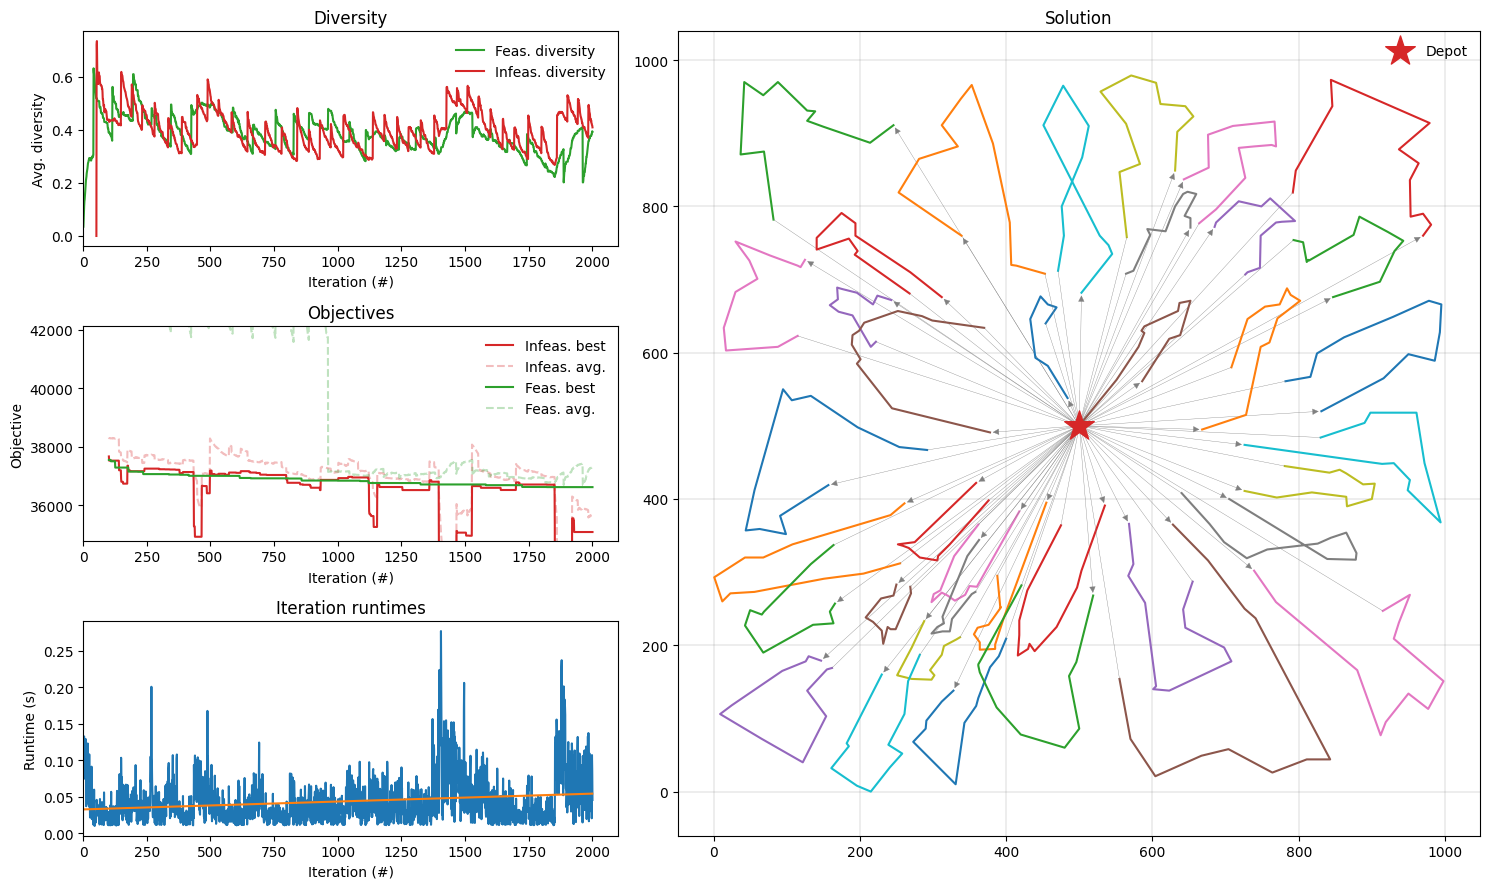

In [10]:
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()

PyVRP internally uses a genetic algorithm consisting of a population of feasible and infeasible solutions.
These solutions are iteratively combined into new offspring solutions, that should result in increasingly better solutions.
Of course, the solutions should not all be too similar: then there is little to gain from combining different solutions.
The top-left *Diversity* plot tracks the average diversity of solutions in each of the feasible and infeasible solution populations.
The *Objectives* plot gives an overview of the best and average solution quality in the current population.
The bottom-left figure shows iteration runtimes in seconds.
Finally, the *Solution* plot shows the best observed solution.

### Quantum-Inspired Evolutionary Algorithm Section

This section tests and compare the Quantum-Inspired Evolutionary Algorithm with Genetic Algorithm.

### Note

Due to how the package installs `X-n439-k37.vrp` and `X-n439-k37.sol` must be manually inserted from examples/data into contents folder to run.

In [3]:
INSTANCE = read("/content/X-n439-k37.vrp", round_func="round")
BKS = read_solution("/content/X-n439-k37.sol")

In [3]:
modelqci = Model.from_data(INSTANCE)
result = modelqci.solveqci(stop=MaxIterations(2000), seed=42, display=False)
print(result)

AttributeError: 'numpy.ndarray' object has no attribute 'is_feasible'

In [ ]:
gap = 100 * (result.cost() - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {result.cost()}.")
print(f"This is {gap:.1f}% worse than the best known", end=" ")
print(f"solution, which is {BKS['cost']}.")

Found a solution with cost: 36627.
This is 0.6% worse than the best known solution, which is 36391.


## The VRP with time windows

### Reading the instance

We start with a basic example that loads an instance and solves it using the standard configuration used by the `Model` interface.
For the basic example we use one of the well-known Solomon instances.

We again use the function `pyvrp.read`. We pass the argument `round_func="dimacs"` following the [DIMACS VRP challenge](http://dimacs.rutgers.edu/programs/challenge/vrp/) convention, this computes distances and durations truncated to one decimal place.

In [ ]:
INSTANCE = read("/content/RC208.vrp", round_func="dimacs")
BKS = read_solution("/content/RC208.sol")

Let's plot the instance and see what we have.
The function `plot_instance` will plot time windows, delivery demands and coordinates, which should give us a good impression of what the instance looks like.
These plots can also be produced separately by calling the appropriate `plot_*` function: see [the API documentation](https://pyvrp.readthedocs.io/en/latest/api/plotting.html) for details.

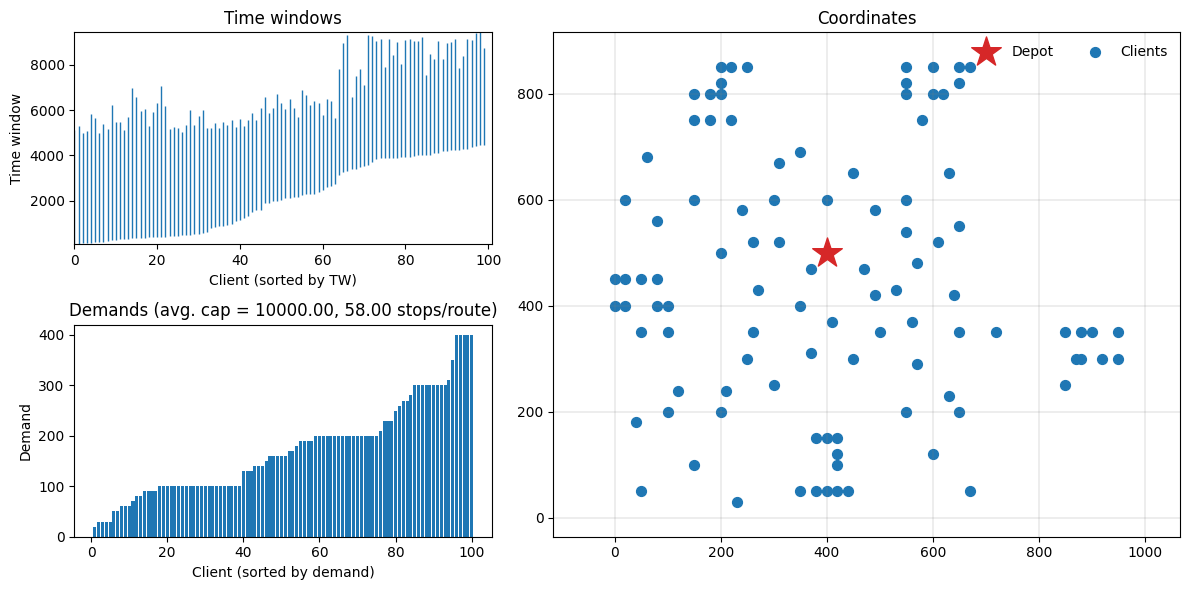

In [ ]:
fig = plt.figure(figsize=(12, 6))
plot_instance(INSTANCE, fig)

### Solving the instance

We will again use the `Model` interface to solve the instance.

In [ ]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxIterations(1000), seed=42, display=False)
print(result)

Solution results
    # routes: 4
     # trips: 4
   # clients: 100
   objective: 7761
    distance: 7761
    duration: 17761
# iterations: 1000
    run-time: 7.23 seconds

Routes
------
Route #1: 90 65 82 99 52 83 64 49 19 18 48 21 23 25 77 58 75 97 59 87 74 86 57 24 22 20 66
Route #2: 94 92 95 67 62 50 34 31 29 27 26 28 30 32 33 76 89 63 85 51 84 56 91 80
Route #3: 61 42 44 39 38 36 35 37 40 43 41 72 71 93 96 54 81
Route #4: 69 98 88 2 6 7 79 73 78 12 14 47 17 16 15 13 9 11 10 53 60 8 46 4 45 5 3 1 70 100 55 68



In [ ]:
cost = result.cost() / 10
gap = 100 * (cost - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {cost}.")
print(f"This is {gap:.1f}% worse than the optimal solution,", end=" ")
print(f"which is {BKS['cost']}.")

Found a solution with cost: 776.1.
This is 0.0% worse than the optimal solution, which is 776.1.


We've managed to find a (near) optimal solution in a few seconds!

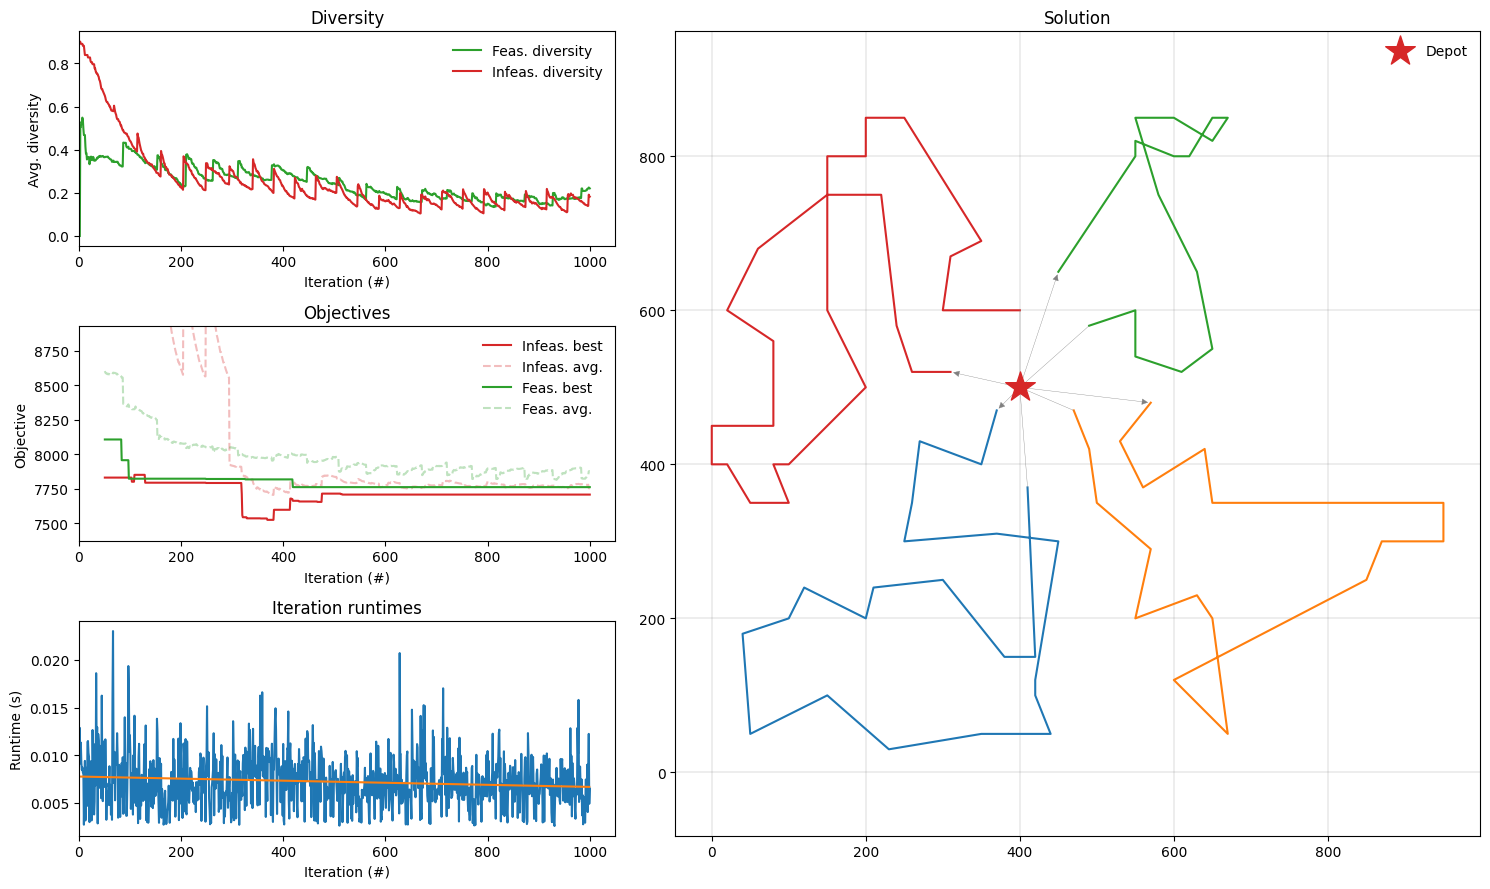

In [ ]:
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()

We can also inspect some statistics of the different routes, such as route distance, various durations, the number of stops and total delivery amount.

In [ ]:
solution = result.best
routes = solution.routes()

data = [
    {
        "num_stops": len(route),
        "distance": route.distance(),
        "service_duration": route.service_duration(),
        "wait_duration": route.wait_duration(),
        "time_warp": route.time_warp(),
        "delivery": route.delivery(),
    }
    for route in routes
]

tabulate(data, headers="keys", tablefmt="html")

num_stops,distance,service_duration,wait_duration,time_warp,delivery
27,2187,2700,0,0,[4650]
24,1983,2400,0,0,[3810]
17,1325,1700,0,0,[2860]
32,2266,3200,0,0,[5920]


We can inspect the routes in more detail using the `plot_route_schedule` function.
This will plot distance on the x-axis, and time on the y-axis, separating actual travel/driving time from waiting and service time.
The clients visited are plotted as grey vertical bars indicating their time windows.
In some cases, there is slack in the route indicated by a semi-transparent region on top of the earliest time line.
The grey background indicates the remaining load of the truck during the route, where the (right) y-axis ends at the vehicle capacity.

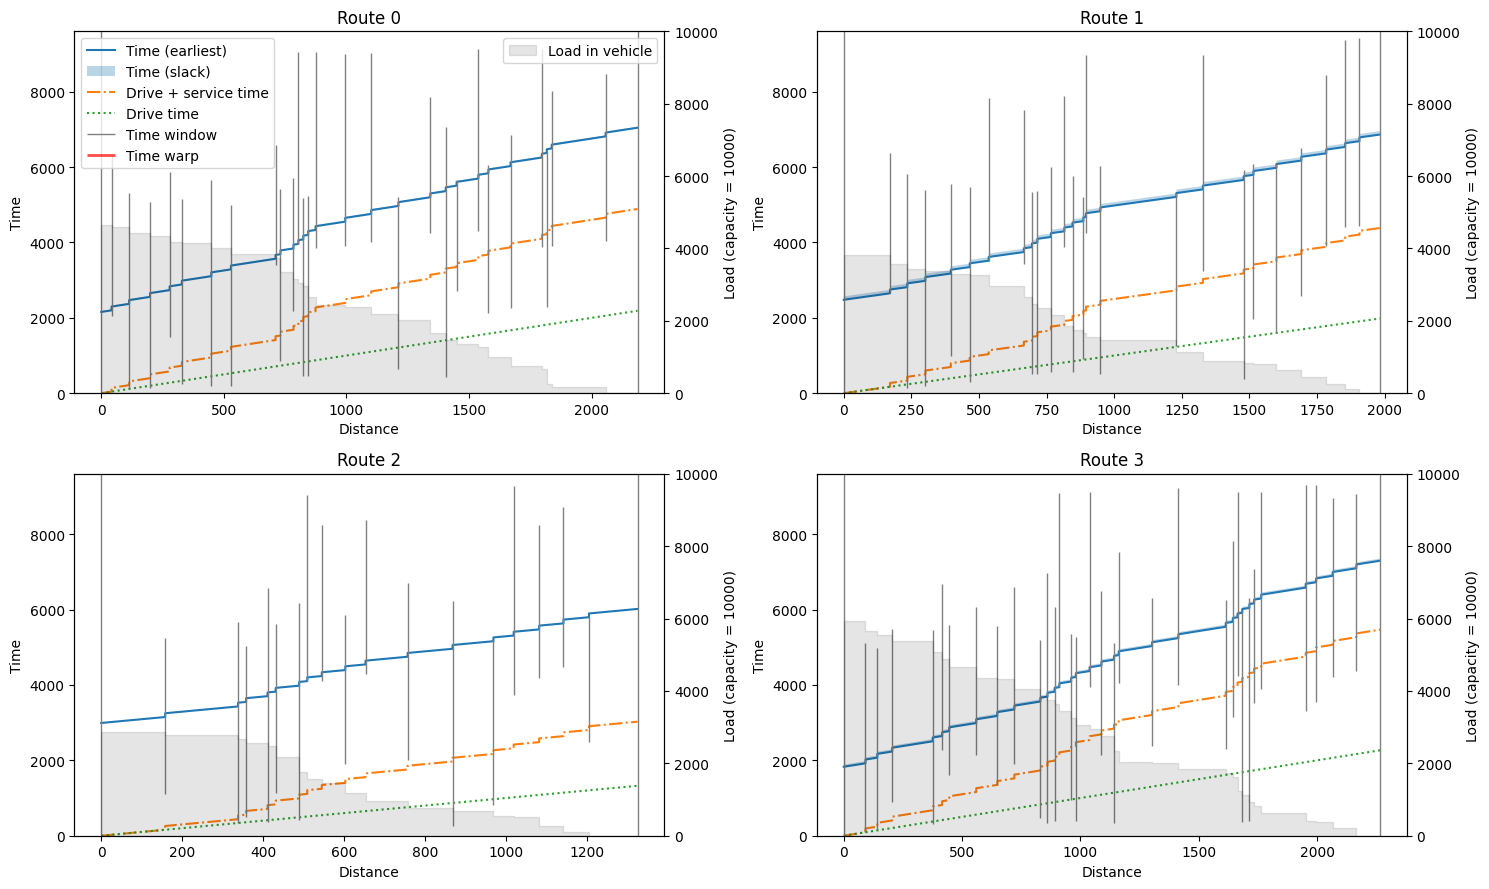

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 9))
for idx, (ax, route) in enumerate(zip(axarr.flatten(), routes)):
    plot_route_schedule(
        INSTANCE,
        route,
        title=f"Route {idx}",
        ax=ax,
        legend=idx == 0,
    )

fig.tight_layout()

Each route begins at a given `start_time`, that can be obtained as follows.
Note that this start time is typically not zero, that is, routes do not have to start immediately at the beginning of the time horizon.

In [ ]:
solution = result.best
shortest_route = min(solution.routes(), key=len)

shortest_route.start_time()

2991

Some of the statistics presented in the plots above can also be obtained from the route schedule, as follows:

In [ ]:
data = [
    {
        "location": visit.location,  # Client or depot location of visit
        "start_service": visit.start_service,
        "end_service": visit.end_service,
        "service_duration": visit.service_duration,
        "wait_duration": visit.wait_duration,  # if vehicle arrives early
    }
    for visit in shortest_route.schedule()
]

tabulate(data, headers="keys", tablefmt="html")

location,start_service,end_service,service_duration,wait_duration
0,2991,2991,0,0
61,3149,3249,100,0
42,3429,3529,100,0
44,3549,3649,100,0
39,3702,3802,100,0
38,3822,3922,100,0
36,3980,4080,100,0
35,4100,4200,100,0
37,4236,4336,100,0
40,4394,4494,100,0


## Solving a larger VRPTW instance

To show that PyVRP can also handle much larger instances, we will solve one of the largest Gehring and Homberger VRPTW benchmark instances.
The selected instance - `RC2_10_5` - has 1000 clients.

In [ ]:
INSTANCE = read("/content/RC2_10_5.vrp", round_func="dimacs")
BKS = read_solution("/content/RC2_10_5.sol")

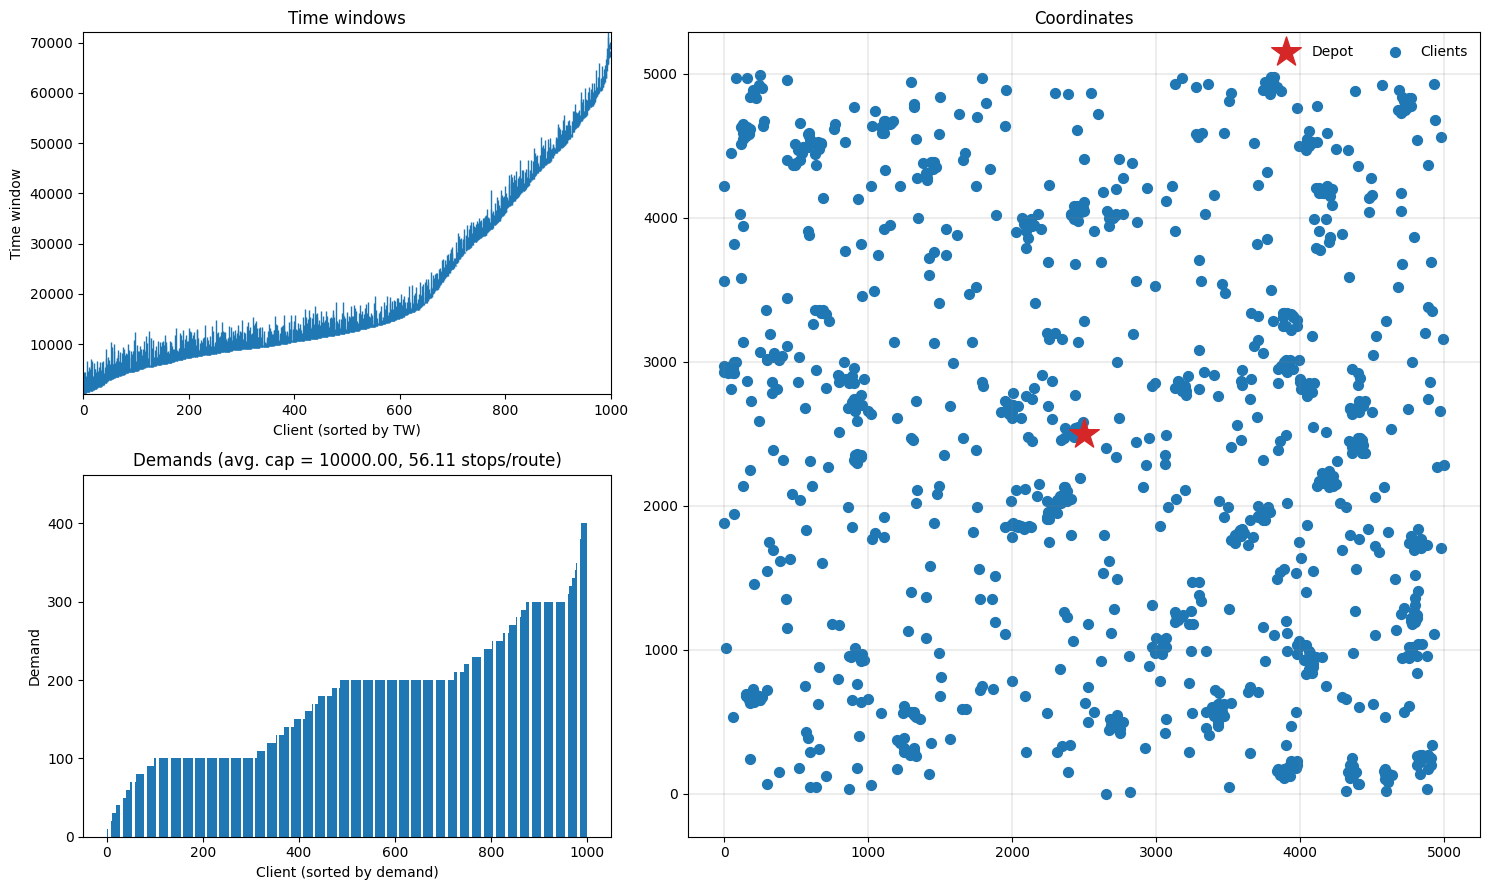

In [ ]:
fig = plt.figure(figsize=(15, 9))
plot_instance(INSTANCE, fig)

Here, we will use a runtime-based stopping criterion: we give the solver 30 seconds to compute.

In [ ]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxRuntime(30), seed=42, display=False)

In [ ]:
cost = result.cost() / 10
gap = 100 * (cost - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {cost}.")
print(f"This is {gap:.1f}% worse than the best-known solution,", end=" ")
print(f"which is {BKS['cost']}.")

In [ ]:
plot_result(result, INSTANCE)
plt.tight_layout()

## Conclusion

In this notebook, we used PyVRP's `Model` interface to solve a CVRP instance with 438 clients to near-optimality, as well as several VRPTW instances, including a large 1000 client instance.
Moreover, we demonstrated how to use the plotting tools to visualise the instance and statistics collected during the search procedure.